## Outline the Machine Learning model
This workflow exemplfies the proceedure to make a simple hydrological machine learning model using remote sensing data products available through Google Earth Engine. 

![ML_workflow.JPG](./Images/ML_workflow.JPG)

In this chapter we will:

1. Select a prediction location based on in situ USGS National Water Information Systems (NWIS) data availability
2. Connect to Google Earth Engine and select applicable hydrometeorological features for input into a model
3. Create a normalized dataframe to train a machine learning model

## Find a Streamflow Prediction location

Go to the [USGS National Water Information System: Mapper](https://maps.waterdata.usgs.gov/mapper/index.html) and find a surface water monitoring location with ample record (>10 years).

Lets look at USGS site 10172200,  Red Butte Creek at Fort Douglass, Near SLC, UT, 10133800 East Canyon Near Park City, UT, and 10133600 Mcleod creek Near Park City, UT.

![USGS_Locations](./Images/USGS_sites.jpg)


In [1]:
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Get_StreamStats
from scipy import optimize
from datetime import datetime, date
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def NWIS_retrieve(site, startDT, endDT):
    service = IVDataService()
    usgs_data = service.get(
        sites=site,
        startDT= startDT,
        endDT= endDT
        )
    return usgs_data    

from platform import python_version

print(python_version())

C:\Users\rjohnson18\Anaconda3\envs\GEE_env\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


3.9.12


In [204]:
start = '2020-1-1'
end = '2022-12-31'
NWISids = ['10172200', '10133800', '10133600']

#create dictionary for streams
flow = {}
for site in NWISids:
    print('Getting streamflow data for ', site)
    flow[site] = NWIS_retrieve(site, start, end)

    #make the date the index for plotting and resampling
    flow[site]['datetime'] = flow[site]['value_time']
    flow[site].set_index('datetime', inplace = True)

    #clean the data
    flow[site] = flow[site][flow[site]['value'] > 0]
    
    #resample to a daily resolution
    flow[site] = pd.DataFrame(flow[site]['value']).rename(columns = {'value':'flow_cfs'})
    flow[site] = flow[site].resample('D').mean()
    flow[site]['NWIS_site_id'] = site

Getting streamflow data for  10172200
Getting streamflow data for  10133800
Getting streamflow data for  10133600


In [205]:
flow['10133800']

,flow_cfs,NWIS_site_id
datetime,,
2020-01-01,16.316303,10133800
2020-01-02,16.793749,10133800
2020-01-03,17.435415,10133800
2020-01-04,16.716667,10133800
2020-01-05,18.015625,10133800
...,...,...
2022-12-27,15.869792,10133800
2022-12-28,24.381250,10133800
2022-12-29,22.133333,10133800


## Dataframe check
Lets explore the data:

1. What is the temporal resolution?
2. What are the dataframe headers/columns?
3. What variable are we seeing and in what units?
4. How many observations are there?

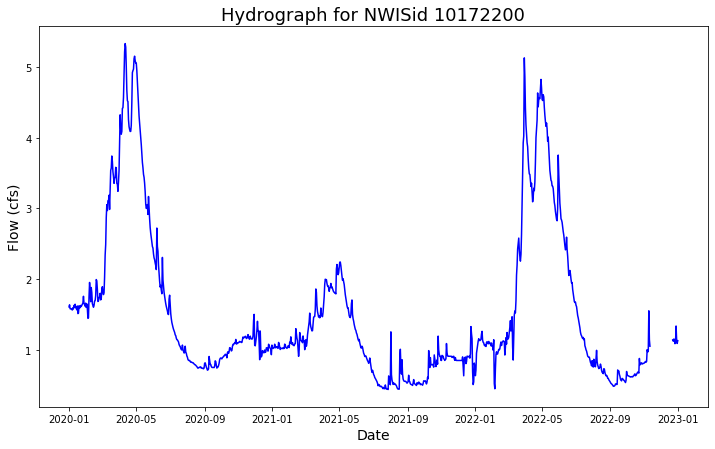

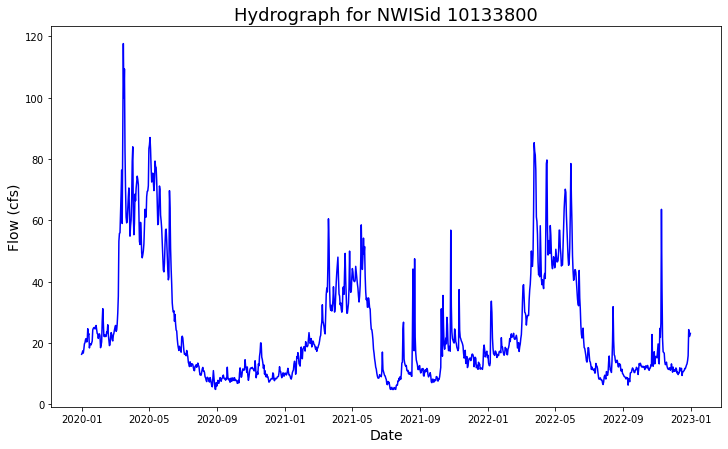

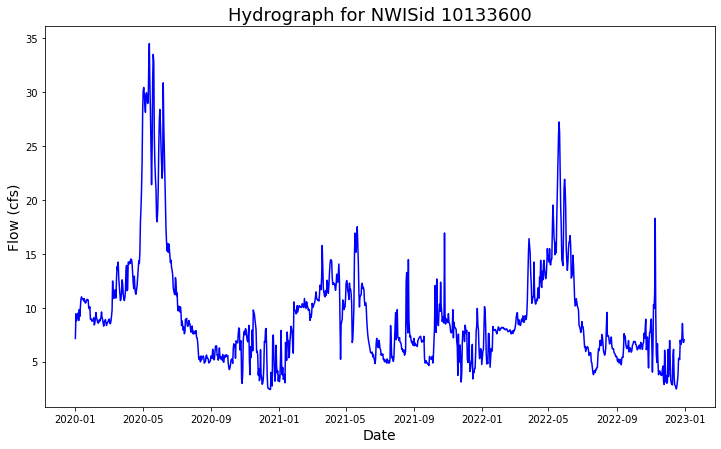

In [186]:

for site in NWISids:
# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis
    #y-axis
    ymin = min(flow[site]['flow_cfs'])*1.1
    ymax = max(flow[site]['flow_cfs'])*1.1
    title = 'Hydrograph for NWISid '+site

    #set colors
    color_f = 'blue'


    # Add flow to plot.
    ax.plot(flow[site].index, flow[site]['flow_cfs'],
               c=color_f, label='Flow (cfs)')
    ax.set_ylabel('Flow (cfs)', fontsize = 14)
    ax.set_xlabel('Date',  fontsize = 14)
    ax.set_title(title, fontsize = 18)

    plt.show()

In [190]:
def hydrographs(flow, NWISids):
    # Subplots.
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    fig.patch.set_facecolor('white')

    #set colors
    color_f = 'blue'


    # Add flow to plot.
    for site in NWISids:
        ax.plot(flow[site].index, flow[site]['flow_cfs'], label= site)
    ax.set_ylabel('Streamflow (cfs)', fontsize = 14)
    ax.set_xlabel('Date',  fontsize = 14)
    ax.set_title('Hydrographs', fontsize = 18)
    ax.legend()

    plt.show()

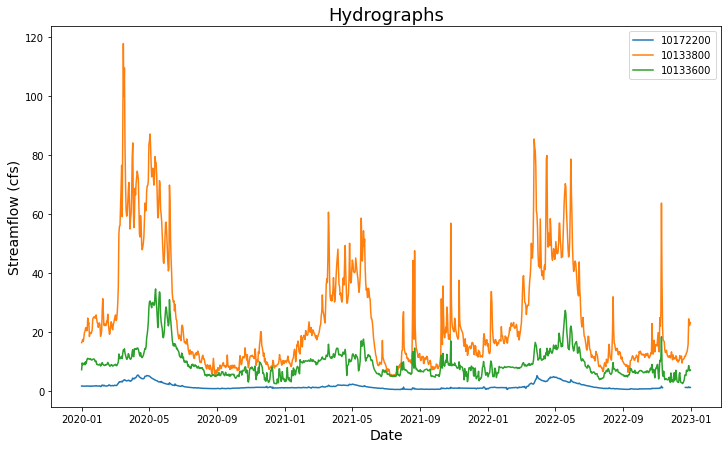

In [191]:
hydrographs(flow, NWISids)

## Catchment Characteristics
Streamflow is highly correlated to the underlying catchment characteristics, such as:
1. Area
2. Elevation
3. Land Cover
4. Water resources infrastructure (dams, diversions, etc.)

Lets get some catchment statistics using [StreamStats](https://streamstats.usgs.gov/ss/)

![StreamStats](./Images/StreamStats.JPG)


In [214]:
#Use the Get_StreamStats functions to get StreamStats information
StreamStats = Get_StreamStats.get_USGS_site_info(NWISids)

#save dataframe for further use
StreamStats.to_csv('./Data/StreamStats2.csv')

Calculating NWIS streamflow id characteristics for  3 sites
NWIS site:  10172200


502 error, StreamStats down, using backup files
Retrieving Drainage Area
Retrieving Mean Catchment Elevation
Retrieving Catchment Land Cover Information
Retrieving Catchment Topographic Complexity
Retrieving Catchment Average Precip
['10172200', 40.77994627, -111.806045, 7.22, 6810.0, 43.1, 0.0, 0.00359, 8.68, 88.3, 35.6]
NWIS site:  10133800


502 error, StreamStats down, using backup files
Retrieving Drainage Area
Retrieving Mean Catchment Elevation
Retrieving Catchment Land Cover Information
Retrieving Catchment Topographic Complexity
Retrieving Catchment Average Precip
['10133800', 40.75966979, -111.5640912, 64.6, 7420.0, 65.4, 13.1, 3.65, 2.63, 36.3, 26.2]
NWIS site:  10133600


502 error, StreamStats down, using backup files
Retrieving Drainage Area
Retrieving Mean Catchment Elevation
Retrieving Catchment Land Cover Information
Retrieving Catchment Topographic Complexity
Retrieving Catchment Average Precip
['10133600', 40.68803889, -111.5337194, 16.3, 7890.0, 69.5, 14.3, 4.08, 1.62, 48.3, 21.5]


Lets take a look at the catchment characteristics of these sites. Are all of the observations present? If not, they may need to be manually added using [StreamStats](https://streamstats.usgs.gov/ss/)

In [7]:
StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6
1,10133800,40.75967,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2
2,10133600,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5


![GEE](./Images/GEE.png)

# Use Google Earth Engine to collect data for a point

[Google Earth Engine catalog](https://developers.google.com/earth-engine/datasets/catalog/) offers an assortment of ready to use remote sensing products.
Before using GEE in Jupyter, you will need to install GEE for Jupyter using this [link](https://developers.google.com/earth-engine/guides/python_install) while following the [Conda](https://developers.google.com/earth-engine/guides/python_install-conda) instructions as well as following the installation guide [Google Earth Engine](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).
Note, you must have an active gmail account to use GEE.

In [8]:
#Connect to Earth Engine to get NLDAS Temperature and Precipitation
import ee
import EE_funcs
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNubwK2pHHEyGGog9jDfbQn_MOYfpZXPIl0PGmArdj1_LwlPKPeJxo

Successfully saved authorization token.


### Lets get some data

[NLDAS](https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002#bands) precipitation and temperature

In [9]:
#NLDAS temperature
temp = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('temperature').filterDate(start, end)

#NLDAS precipitation
precip = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('total_precipitation').filterDate(start, end)


In [10]:
# Define slc location of interest, lets use the USGS guage locations!
lon = {}
lat = {}
poi = {}

for site in np.arange(0,len(NWISids),1):
    lon[site] = StreamStats['Long'][site]
    lat[site] = StreamStats['Lat'][site]
    poi[site] = ee.Geometry.Point(lon[site], lat[site])

scale = 1000  # scale in meters

In [12]:
# Calculate and print the mean value of the LST collection at the point.
for site in np.arange(0,len(NWISids),1):
    site_temp = temp.mean().sample(poi[site], scale).first().get('temperature').getInfo()
    print('Average daytime temperature at USGS Station: ', StreamStats['NWIS_site_id'][site], ' is ',   round(site_temp, 2), '°C')

Average daytime temperature at USGS Station:  10172200  is  8.44 °C
Average daytime temperature at USGS Station:  10133800  is  6.91 °C
Average daytime temperature at USGS Station:  10133600  is  5.52 °C


In [13]:
# Calculate and print the mean value of the precip collection at the point.
kg_in = 0.04
for site in np.arange(0,len(NWISids),1):
    site_precip = precip.mean().sample(poi[site], scale).first().get('total_precipitation').getInfo()
    print('Average hourly precipitation at USGS Station: ', StreamStats['NWIS_site_id'][site], ' is ', round(site_precip*kg_in, 4), 'in')

Average hourly precipitation at USGS Station:  10172200  is  0.0022 in
Average hourly precipitation at USGS Station:  10133800  is  0.0034 in
Average hourly precipitation at USGS Station:  10133600  is  0.0041 in


In [14]:
# Get the data for the pixel intersecting the point at each station
temp_poi = {}
precip_poi = {}
for site in np.arange(0,len(NWISids),1):
    name = StreamStats['NWIS_site_id'][site]
    temp_poi[name] = temp.getRegion(poi[site], scale).getInfo()
    precip_poi[name] = precip.getRegion(poi[site], scale).getInfo()


# Preview the result.
temp_poi['10172200'][:5]

[['id', 'longitude', 'latitude', 'time', 'temperature'],
 ['A20200101_0000',
  -111.80881183793625,
  40.77902232260568,
  1577836800000,
  -5.759999999999991],
 ['A20200101_0100',
  -111.80881183793625,
  40.77902232260568,
  1577840400000,
  -6.139999999999986],
 ['A20200101_0200',
  -111.80881183793625,
  40.77902232260568,
  1577844000000,
  -6.519999999999982],
 ['A20200101_0300',
  -111.80881183793625,
  40.77902232260568,
  1577847600000,
  -6.899999999999977]]

In [201]:
#Convert pointer object array to dataframe to work with
temp = {}
precip = {}
for site in np.arange(0,len(NWISids),1):
    name = StreamStats['NWIS_site_id'][site]
    temp[name] = EE_funcs.ee_array_to_df(temp_poi[name],['temperature'])
    precip[name] = EE_funcs.ee_array_to_df(precip_poi[name],['total_precipitation'])
    #need to add in time to precip data, same daterange as temperaure
    precip[name]['time'] = temp[name]['time']

In [202]:
def dict_to_df(DF, temporal_resample, variable):
    var_df = pd.DataFrame()
    for site in DF:
        DF[site].set_index('datetime', inplace = True)
        
        if variable == 'temperature':
            #make columns for Fahrenheit
            DF[site] = DF[site].resample(temporal_resample).max()
            DF[site].reset_index(inplace = True)
            DF[site]['temperature_F'] = (DF[site]['temperature']*9/5)+32 
            DF[site].pop('temperature')
            DF[site]['NWIS_site_id'] = site
        if variable == 'total_precipitation':
            DF[site] = DF[site].resample(temporal_resample).sum()
            DF[site].reset_index(inplace = True)
            #make columns for inches
            DF[site]['precipitation_in'] = DF[site]['total_precipitation']*kg_in
            DF[site].pop('total_precipitation')
            DF[site]['NWIS_site_id'] = site
            
        var_df = var_df.append(DF[site])
    
    var_df.reset_index(inplace=True, drop=True)
    return var_df, DF
            
            

## For fun, define a fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

In [203]:
#resample to the desired temporal scale, take the respective statistic from the data of resampling
temporal_resample = 'D'

T, T_DF = dict_to_df(temp, temporal_resample, 'temperature')
P, P_DF = dict_to_df(precip, temporal_resample, 'total_precipitation')

Clim_DF = pd.merge(T, P,on=['datetime', 'NWIS_site_id'])
Clim_DF.pop('time')
Clim_DF

,datetime,temperature_F,NWIS_site_id,precipitation_in
0,2020-01-01,30.506,10172200,0.260400
1,2020-01-02,30.866,10172200,0.128416
2,2020-01-03,30.218,10172200,0.040376
3,2020-01-04,30.398,10172200,0.011112
4,2020-01-05,28.436,10172200,0.008684
...,...,...,...,...
3280,2022-12-26,38.066,10133600,0.052752
3281,2022-12-27,35.600,10133600,0.517000
3282,2022-12-28,33.206,10133600,1.418972
3283,2022-12-29,25.736,10133600,0.122988


In [196]:
T

,datetime,time,temperature_F,NWIS_site_id
0,2020-01-01,1577919600000,30.506,10172200
1,2020-01-02,1578006000000,30.866,10172200
2,2020-01-03,1578092400000,30.218,10172200
3,2020-01-04,1578178800000,30.398,10172200
4,2020-01-05,1578265200000,28.436,10172200
...,...,...,...,...
3280,2022-12-26,1672095600000,38.066,10133600
3281,2022-12-27,1672182000000,35.600,10133600
3282,2022-12-28,1672268400000,33.206,10133600
3283,2022-12-29,1672354800000,25.736,10133600


## Lets plot the climate information

How does precipitation and temperature compare in different watersheds?


In [197]:
def temp_precip_plt(P_DF, T_DF, NWISids):
    
    # Fitting curves.
    ## Optimize the parameters using a good start p0.
    lst0 = 20
    delta_lst = 40
    tau = 365*24*3600*1000   # milliseconds in a year
    phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0


    ## First, extract x values (times) from the dfs.
    x_data_t = {}
    y_data_t = {}
    params_t = {}
    params_covariance_t = {} 


    for site in NWISids:
        P_DF[site]['time'] = T_DF[site]['time']
        x_data_t[site] = np.asanyarray(T_DF[site]['time'].apply(float))  # temperature
        y_data_t[site] = np.asanyarray(T_DF[site]['temperature_F'].apply(float))  # temperature

        #Temperature
        params_t[site], params_covariance_t[site] = optimize.curve_fit(
            fit_func, x_data_t[site], y_data_t[site], p0=[lst0, delta_lst, tau, phi])


    # Subplots.
    fig, ax = plt.subplots(2,1, figsize=(10, 10))
    fig.patch.set_facecolor('white')


    #set colors #https://matplotlib.org/stable/gallery/color/named_colors.html
    color_t = ['orange','red', 'sienna'] 
    color_p = ['deepskyblue', 'steelblue', 'blue']


    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[0].scatter(T_DF[name]['datetime'], T_DF[name]['temperature_F'],
                   c=color_t[site], alpha=0.35, label=name)

        # Add temperature fitting curve.
        ax[0].plot(T_DF[name]['datetime'],
                fit_func(x_data_t[name], params_t[name][0], params_t[name][1], params_t[name][2], params_t[name][3]),
                color=color_t[site], lw=2.5)
    ax[0].hlines(y=32, xmin=min(T_DF[name]['datetime']), xmax=max(T_DF[name]['datetime']), linewidth=1, 
                     color='darkblue', label = 'freezing')

    # Add some parameters.
    ax[0].set_title('Temperature for Utah Watersheds', fontsize=16, pad=40)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Temperature [$^\circ$F]', fontsize=14, color = 'red')
    ax[0].tick_params(axis='y', labelcolor='red')

    #add freezing pt horizontal line

    ax[0].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[0].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.07, 1.15))

    #now plot precipitation
    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[1].scatter(P_DF[name]['datetime'], P_DF[name]['precipitation_in'],
                   c=color_p[site], alpha=0.35, label=name)


    # Add some parameters.
    ax[1].set_title('Precipitation for Utah Watersheds', fontsize=16, pad=40)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].set_ylabel('Precipitation [in]', fontsize=14, color = 'blue')
    ax[1].tick_params(axis='y', labelcolor='blue')

    ax[1].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[1].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.15, 1.15))



    fig.tight_layout()
    plt.show()

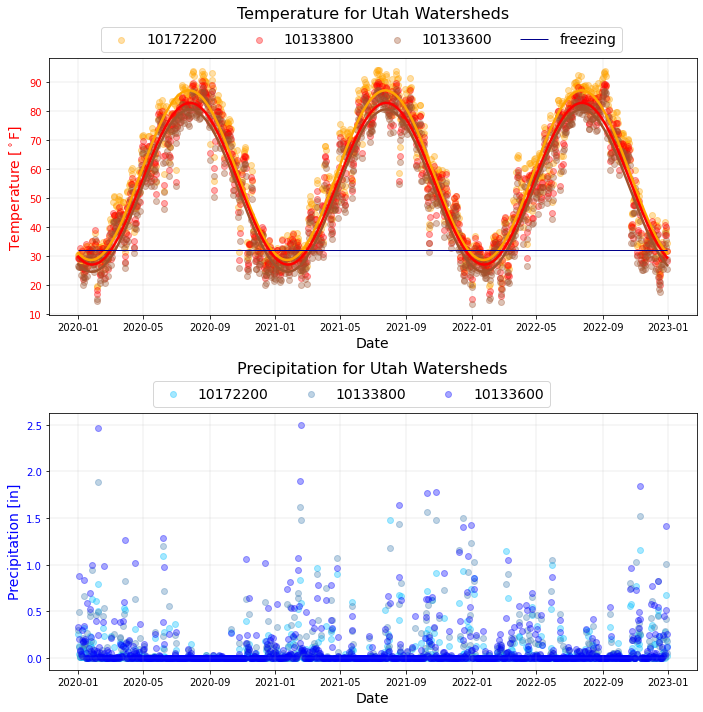

In [198]:
temp_precip_plt(P_DF, T_DF, NWISids)

## Precipitation data is not very useful here
We can distinguish the precipitation data between sites but the precipitation data is a different story.
Lets see how we can resample the data to help with this. 

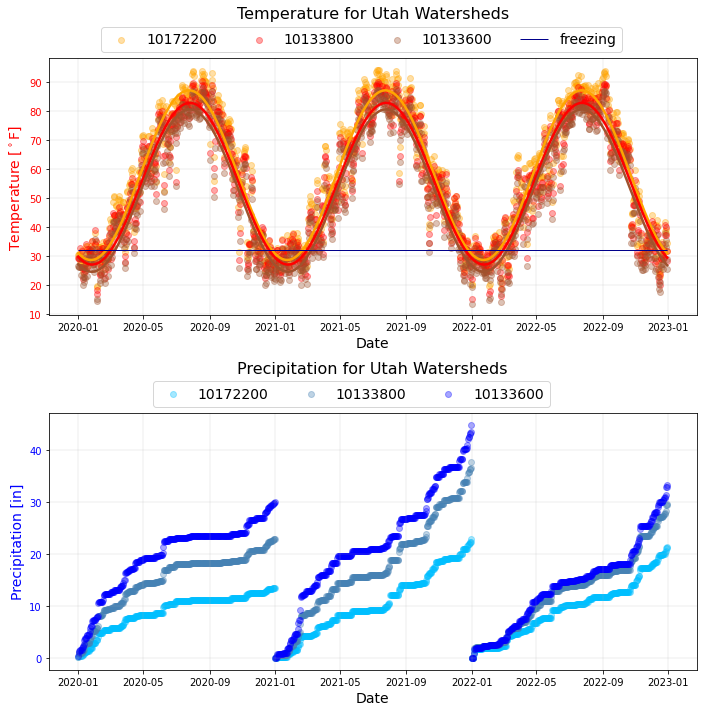

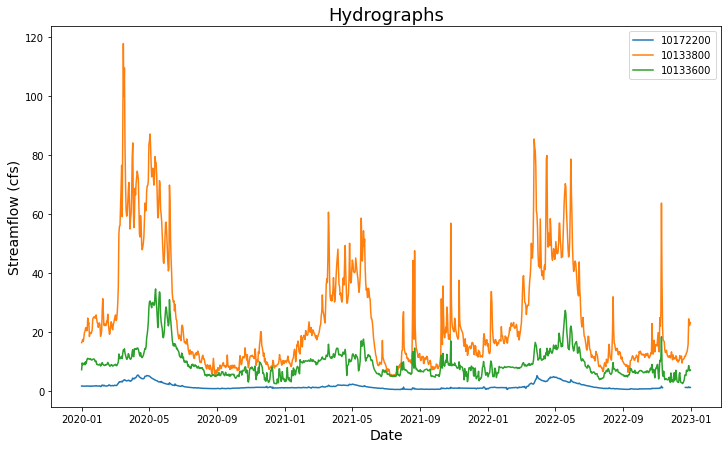

In [199]:
#Aggregate the precipitation per year
Precip_Total = {}
for site in NWISids:
    Precip_Total[site]=P_DF[site].copy()
    Precip_Total[site].set_index('datetime', inplace =True)
    Precip_Total[site].pop('time')
    Precip_Total[site]['Year'] = Precip_Total[site].index.year
    Precip_Total[site]['precipitation_in'] = Precip_Total[site].groupby(['Year'])['precipitation_in'].cumsum()
    Precip_Total[site].reset_index(inplace = True)
#lets plot again
temp_precip_plt(Precip_Total, T_DF, NWISids)
#lets plot the hydrographs again to see if we see any similarities
hydrographs(flow, NWISids)

## Lets Create a DataFrame with all of the information for training a ML model!

We have looked at daily resolution temperature and precipitation, so lets stay at this resolution. 
The NLDAS data is available at 1 hr temporal resolution with the ability to resample to an greater timestep using the [resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) function.

The [Merge, Join, Concatenate and Compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) functions will be most useful here.

In [19]:
#Lets begin with the temperature and precipitation data
Training_DF = temp_RB.copy()

#remote unnecessary columns, time, temperature
colrem = ['time', 'temperature']
Training_DF.drop(colrem, axis =1, inplace =True)

#lets add the precipitation data
Training_DF['precipitation_in'] = precip_RB['precipitation_in']

#set index to datetime
Training_DF.set_index('datetime', drop = True, inplace = True)

#lets add streamflow, but we need to make it at the same temporal resolution (daily)
cols = ['value']
flow = flow[cols]
flow = flow.resample(temporal_resample).mean()
flow.rename(columns ={'value':'flow_cfs'}, inplace = True)

#concat dataframe by date
Training_DF = pd.concat([Training_DF, flow], axis = 1).dropna()

#Add the NWIS id to match with StreamStats
Training_DF['NWIS_site_id'] = NWISid

In [20]:
Training_DF

,temperature_F,precipitation_in,flow_cfs,NWIS_site_id
datetime,,,,
2020-01-01,30.506,0.260400,1.607283,10172200
2020-01-02,30.866,0.128416,1.636875,10172200
2020-01-03,30.218,0.040376,1.580729,10172200
2020-01-04,30.398,0.011112,1.580000,10172200
2020-01-05,28.436,0.008684,1.582188,10172200
...,...,...,...,...
2022-12-26,41.900,0.279984,1.087500,10172200
2022-12-27,39.326,0.204304,1.100500,10172200
2022-12-28,37.868,0.679064,1.337188,10172200


In [217]:
#Lets make our final dataframe with climate, streamstats, and flow
#Connect Streamstats with the climate dataframe
Training_DF = pd.merge(Clim_DF, StreamStats,on=['NWIS_site_id'])

#Day of year (DOY) is likely an important feature, lets convert date time to DOY
Training_DF['DOY'] = Training_DF.datetime.dt.dayofyear

#now add flow, first we covert flow from a dictionary to a dataframe
Flow_DF = pd.DataFrame()
for site in NWISids:
    Flow_DF = Flow_DF.append(flow[site])
Flow_DF.reset_index(inplace = True)    
Training_DF = pd.merge(Training_DF, Flow_DF,on=['datetime', 'NWIS_site_id'])

#What feature are relevant. Lets remove NWIS_site_id
Training_DF.pop('NWIS_site_id')



#remove old datetime column
Training_DF.pop('datetime')

#save DataFrame for Model Development
Training_DF.to_csv('./Data/Training_DF2.csv')

In [218]:
Training_DF

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,DOY,flow_cfs
0,30.506,0.260400,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,1,1.607283
1,30.866,0.128416,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,2,1.636875
2,30.218,0.040376,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,3,1.580729
3,30.398,0.011112,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,4,1.580000
4,28.436,0.008684,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6,5,1.582188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,38.066,0.052752,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,360,6.631250
3281,35.600,0.517000,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,361,7.216562
3282,33.206,1.418972,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,362,8.534375
3283,25.736,0.122988,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,363,7.092917


# Exercise

Here, we created a dataframe to train an ML model for one watershed but we would like to use the model for multiple watersheds.

The activity goal here is to add 2 more nearby watersheds to the training dataframe.
Go to the [USGS National Water Information System: Mapper](https://maps.waterdata.usgs.gov/mapper/index.html) once again and find a surface water monitoring location with ample record (>10 years) within 50 miles of the Red Butte Creek location.
Once finished, save the csv as <font color='red'>Training_DF3.csv</font> so we can use it in the next chapter.

Lets see if we can get this completed in the next 30 minutes.

The fancy method would be to create function that takes in the NWISid and automatically adds it to the Training (i.e., the function takes in a list of sites to make a DataFrame).

**Make a copy of this Notebook with your initials_GEE_Workshop_CH1.5, e.g., RJ_GEE_Workshop_CH1.5. Save to the Exercises folder.**

### Next Chapter
Let's put the data to use and make a [real ML model](./GEE_Workshop_CH2.ipynb)!